**Keywords**: Multiclass Classification, Least Squares Regression, PyTorch

**About the dataset**:
*   The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.
*   The MNIST database contains 70,000 labeled images. Each datapoint is a $28\times 28$ pixels grayscale image.
*   However because of compute limitations, we will use a much smaller dataset with size $8\times 8$ images. These images are loaded from `sklearn.datasets`.

**Agenda**:
* Performing multiclass classification on the simplified MNIST dataset.
* Applying Multiclass Logistic Regression from scratch. Working with both Mean Square Error (L2) loss and Cross Entropy (CE) loss with gradient descent (GD) as well as stochastic/mini-batch gradient descent (SGD). 
* Finally, training a 2-hidden-layer Neural Network model on the image dataset.
* All the predictions will be evaluated on a test set.



---



In [1]:
# imports
import torch
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# loading the dataset directly from the scikit-learn library
dataset = load_digits()
X = dataset.data
y = dataset.target
print('Number of images:', X.shape[0])
print('Number of features per image:', X.shape[1])

Number of images: 1797
Number of features per image: 64


In [3]:
# utility function to plot gallery of images
def plot_gallery(images, titles, height, width, n_row=2, n_col=4):
    plt.figure(figsize=(2* n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

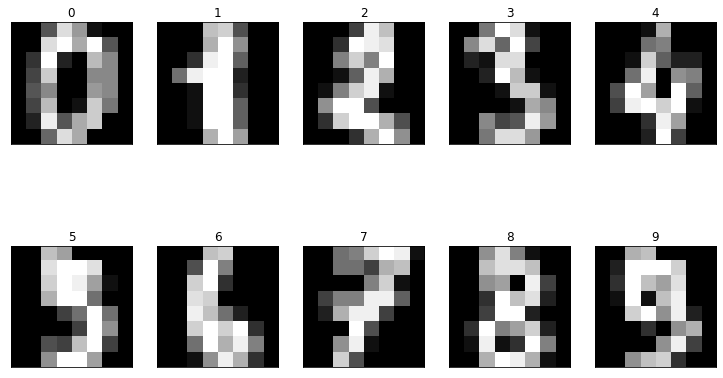

In [4]:
# visualizing some of the images of the MNIST dataset
plot_gallery(X, y, 8, 8, 2, 5)

In [5]:
# Splitting the dataset into training and test sets in a stratified manner.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Shape of train dataset:', X_train.shape)
print('Shape of evaluation dataset:', X_test.shape)

Shape of train dataset: (1437, 64)
Shape of evaluation dataset: (360, 64)


In [6]:
# Defining some constants - useful for later
num_classes = len(np.unique(y)) # number of target classes = 10 -- (0,1,2,3,4,5,6,7,8,9)
num_features = X.shape[1]       # number of features = 64
max_epochs = 100000             # max number of epochs for training
lr = 1e-2                       # learning rate
tolerance = 1e-6                # tolerance for early stopping during training

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'



---



### We will apply multiclass logistic regression from scratch with one-vs-all strategy using gradient descent (GD) as well as stochastic gradient descent (SGD) with Mean Squared Error (MSE) loss.
### We will be using a linear model $y^{(i)} = W \mathbf{x}^{(i)},$ where $ W_{p\times n}= \begin{bmatrix}
\leftarrow & \mathbf{w}_1^\top & \rightarrow \\
\leftarrow & \mathbf{w}_2^\top & \rightarrow\\
 & \vdots &  \\
\leftarrow & \mathbf{w}_p^\top & \rightarrow \\
\end{bmatrix}$, and $p$ is the number of target classes. Also, $\mathbf{x}^{(i)}\in \mathbb{R}^n, y^{(i)}\in \mathbb{R}$, and
### $X = \begin{bmatrix}
\uparrow &  \uparrow & \dotsm &  \uparrow\\
\mathbf{x}^{(1)} & \mathbf{x}^{(2)} & \dotsm & \mathbf{x}^{(m)} \\
\downarrow & \downarrow  & \dotsm & \downarrow  \\
\end{bmatrix}, Y = \begin{bmatrix}
y^{(1)}\\
y^{(2)} \\
\vdots \\
y^{(m)} \\
\end{bmatrix}$, where $m$ is the number of datapoints.


In [8]:
# 1. Scaling the features between 0 and 1 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# 2. One-Hot encoding the target labels

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

y_train_ohe = ohe.fit_transform(y_train.reshape(-1,1)).toarray()

y_test_ohe = ohe.transform(y_test.reshape(-1,1)).toarray()

print('Shape of y_train_ohe:',y_train_ohe.shape)
print('Shape of y_test_ohe:',y_test_ohe.shape)

Shape of y_train_ohe: (1437, 10)
Shape of y_test_ohe: (360, 10)


### Function `linear_model` that takes as input a weight matrix (`W`), bias vector (`b`), and input data matrix of size $m\times n$ (`XT`). This function returns the predictions $\hat{y}$. 

In [10]:
def linear_model(W,b,Input):

    y = torch.add(torch.matmul(Input,W.T),b)

    return y

### Function `mse_loss` that takes as input prediction (`y_pred`) and actual labels (`y`), and returns the MSE loss.
$\displaystyle MSE = \frac{1}{m}\sum_{i=1}^m(\hat{y}^{(i)}-y^{(i)})^2$, where $m$ is the number of examples, $\hat{y}^{(i)}$ is the 
predicted value and $y^{(i)}$ is the ground truth.

In [11]:
def mse_loss(y_pred,y_actual):

    loss = (torch.square(y_pred - y_actual)).mean()
    
    return loss

### Function: `initializeWeightsAndBiases` that returns tuple `(W, b)`, where `W` is a randomly generated torch tensor of size `num_classes x num_features`, and `b` is a randomly generated torch vector of size `num_classes`. For both the tensors, setting `requires_grad=True` in parameters.

In [12]:
def initializeWeightsAndBiases(num_classes,num_features):
    W = torch.rand((num_classes,num_features),requires_grad=True,device=device)
    b = torch.rand((num_classes),requires_grad=True,device=device)
    
    return (W,b)

### Additionally, moving all training and testing data to torch tensors with `dtype=float32`.

In [13]:
X_train_torch = torch.from_numpy(X_train).float().to(device)
X_test_torch = torch.from_numpy(X_test).float().to(device)
y_train_ohe_torch = torch.from_numpy(y_train_ohe).float().to(device)
y_test_ohe_torch = torch.from_numpy(y_test_ohe).float().to(device)

### Implementing the code for training. Given below is a function: `train_linear_regression_model` that takes as input max number of epochs (`max_epochs`), batch size (`batch_size`), Weights (`W`), Biases (`b`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`). It return a tuple `(W,b,losses)` where `W,b` are the trained weigths and biases respectively, and `losses` is a list of tuples of loss logged every $100^{th}$  epoch.

In [14]:
def train_linear_regression_model(max_epochs, batch_size, W, b, X_train, y_train, lr, tolerance):

    losses = []
    prev_loss = float('inf')
    number_of_batches = math.ceil(len(X_train)/batch_size)

    for epoch in tqdm(range(max_epochs)):
        for i in range(number_of_batches):
            X_train_batch = X_train[i*batch_size: (i+1)*batch_size]
            y_train_batch = y_train[i*batch_size: (i+1)*batch_size]

            # 7. do prediction
            y_pred = linear_model(W,b,X_train_batch)
            
            # 8. get the loss
            loss = mse_loss(y_pred,y_train_batch)

            # 9. backpropagate loss
            loss.backward()
            
            # 10. update the weights and biasees
            with torch.no_grad():
                W -= lr * W.grad
                b -= lr * b.grad
            # 11. set the gradients to zero
            W.grad.zero_()
            b.grad.zero_()
            #######

        # log loss every 100th epoch and print every 5000th epoch:
        if epoch%100==0:
            losses.append((epoch, loss.item()))
        if epoch%5000==0:
            print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

        # break if decrease in loss is less than threshold
        if abs(prev_loss-loss)<=tolerance:
            break
        else:
            prev_loss=loss  

    # return updated weights, biases, and logged losses
    return W, b, losses

In [15]:
# initializing these to compare the models later
train_results = []
test_results = []

### Initializing weights and biases using the `initializeWeightsAndBiases` function that was defined earlier, and training the model using function `train_linear_regression_model` defined above. Using full batch (setting `batch_size=len(X_train)` for training (Gradient Descent). Also plotting the graph of loss vs number of epochs (Recall that values for learning rate (`lr`) and tolerance (`tolerance`) are already defined above).

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 113.71159362792969
Epoch: 5000, Loss: 0.1472998410463333
Epoch: 10000, Loss: 0.08794815093278885
Epoch: 15000, Loss: 0.06747237592935562
Epoch: 20000, Loss: 0.05755147337913513


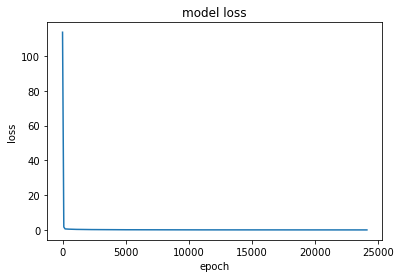

In [16]:
(W,b) = initializeWeightsAndBiases(num_classes,num_features)

def plot_loss(losses):
    plt.plot(*zip(*losses))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

W, b, losses = train_linear_regression_model(max_epochs, len(X_train_torch), W, b, X_train_torch, y_train_ohe_torch, lr, tolerance)

plot_loss(losses)

In [17]:
# print accuracies of model
predictions_train = linear_model(W,b,X_train_torch).to('cpu')
predictions_test = linear_model(W,b,X_test_torch).to('cpu')
y_train_pred = torch.argmax(predictions_train, dim=1).numpy()

y_test_pred = torch.argmax(predictions_test, dim=1).numpy()
print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

test_results.append(("Linear Model - Scratch + MSE Loss + Full Batch",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32))))
train_results.append(("Linear Model - Scratch + MSE Loss + Full Batch",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32))))

Train accuracy: 0.918580375782881
Test accuracy: 0.8944444444444445


### Retraining the above model with `batch_size=64` (Stochastic/Mini-batch Gradient Descent) keeping else everything same. Like before, plotting the graph between loss and number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.04282992705702782


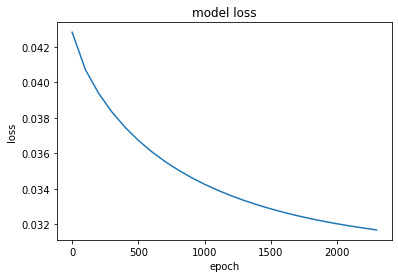

In [18]:
W, b, losses = train_linear_regression_model(max_epochs,64, W, b, X_train_torch, y_train_ohe_torch, lr, tolerance)

plot_loss(losses)

In [19]:
# print accuracies of model
predictions_train = linear_model(W,b,X_train_torch).to('cpu')
predictions_test = linear_model(W,b,X_test_torch).to('cpu')
y_train_pred = torch.argmax(predictions_train, dim=1).numpy()

y_test_pred = torch.argmax(predictions_test, dim=1).numpy()
print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

test_results.append(("Linear Model - Scratch + MSE Loss + Mini Batch",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32))))
train_results.append(("Linear Model - Scratch + MSE Loss + Mini Batch",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32))))

Train accuracy: 0.9457202505219207
Test accuracy: 0.9416666666666667




---



### Previously, we defined the model, loss, and even the gradient update step. We had to manually set the grad to zero. Now, I am re-implementing the linear model and looking at how we can directly use Pytorch to do all this for us in a few simple steps.

In [20]:
# common utility function to print accuracies
def print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test):
    predictions_train = model(X_train_torch).to('cpu')
    predictions_test = model(X_test_torch).to('cpu')
    y_train_pred = torch.argmax(predictions_train, dim=1).numpy()
    y_test_pred = torch.argmax(predictions_test, dim=1).numpy()
    print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
    print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))
  
    return accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)),accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32))


### Defining the linear model using PyTorch

In [21]:
# Defining a model class using torch.nn
class Linear_Model(torch.nn.Module):
    def __init__(self):
        super(Linear_Model, self).__init__()

        # 1. initialzing one linear layer: num_features -> num_targets
        self.fc1 = torch.nn.Linear(num_features, num_classes)
  
    def forward(self, X):
        # 2. defining the feedforward algorithm of the model and return the final output
        output = self.fc1(X)
        return output

### Implementing a general function for training a PyTorch model. Defining a general training function: `train_torch_model` that takes as input an initialized torch model (`model`), batch size (`batch_size`), initialized loss (`criterion`), max number of epochs (`max_epochs`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`). This function will return a tuple `(model, losses)`, where `model` is the trained model, and `losses` is a list of tuples of loss logged every $100^{th}$ epoch. 

In [22]:
# Defining a function train_torch_model
def train_torch_model(model, batch_size, criterion, max_epochs, X_train, y_train, lr, tolerance):
    losses = []
    prev_loss = float('inf')
    number_of_batches = math.ceil(len(X_train)/batch_size)
    
    # 3. move model to device
    model = model.to(device)
    
    # 4. define optimizer (use torch.optim.SGD (Stochastic Gradient Descent)) 
    # Set learning rate to lr and also set model parameters 
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
  
    for epoch in tqdm(range(max_epochs)):
        for i in range(number_of_batches):
            X_train_batch = X_train[i*batch_size: (i+1)*batch_size]
            y_train_batch = y_train[i*batch_size: (i+1)*batch_size]
      
            # 5. reset gradients
            optimizer.zero_grad()
            # 6. prediction
            output=model(X_train_batch)
            # 7. calculate loss
            loss=criterion(output, y_train_batch)
            # 8. backpropagate loss
            loss.backward()
            # 9. perform a single gradient update step
            optimizer.step()
    
        # log loss every 100th epoch and print every 5000th epoch:
        if epoch%100==0:
            losses.append((epoch, loss.item()))
            if epoch%5000==0:
                print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))
        
        # break if decrease in loss is less than threshold
        if abs(prev_loss-loss)<=tolerance:
            break
        else:
            prev_loss=loss  
  
    # return updated model and logged losses
    return model, losses

### Initializing the model and loss function. Using `nn.MSELoss`. Use full batch for training (Gradient Descent). Also plotting the graph of loss vs number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.1907186061143875
Epoch: 5000, Loss: 0.04004666209220886


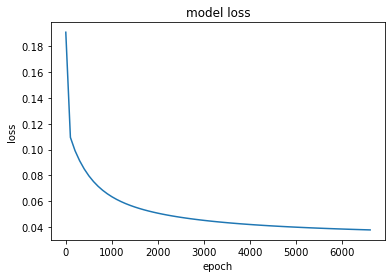

In [23]:
criterion = torch.nn.MSELoss()

model = Linear_Model()

model, losses = train_torch_model(model, len(X_train_torch), criterion, max_epochs, X_train_torch, y_train_ohe_torch, lr, tolerance)

plot_loss(losses)

In [24]:
# print accuracies of model
train_accuracy,test_accuracy= print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

train_results.append(("Linear Model - PyTorch + MSE Loss + Full Batch",train_accuracy))
test_results.append(("Linear Model - PyTorch + MSE Loss + Full Batch",test_accuracy))

Train accuracy: 0.9276270006958942
Test accuracy: 0.9194444444444444


### Retraining the above model with `batch_size=64` (Stochastic/Mini-batch Gradient Descent) keeping else everything same. Like before, plotting the graph between loss and number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.14025552570819855


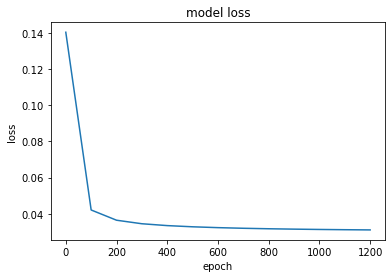

In [25]:
criterion = torch.nn.MSELoss()

model = Linear_Model()

model, losses = train_torch_model(model, 64, criterion, max_epochs, X_train_torch, y_train_ohe_torch, lr, tolerance)

plot_loss(losses)

In [26]:
# print accuracies of model
train_accuracy,test_accuracy = print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

train_results.append(("Linear Model - PyTorch + MSE Loss + Mini Batch",train_accuracy))
test_results.append(("Linear Model - PyTorch + MSE Loss + Mini Batch",test_accuracy))

Train accuracy: 0.9443284620737648
Test accuracy: 0.95




---



### Now, instead of using MSELoss, we will use a much more natural loss function for logistic regression task which is the Cross Entropy Loss.
**Note:**
The [Cross Entropy Loss](https://ebookreading.net/view/book/EB9781789130331_73.html) for multiclass calssification is the mean of the negative log likelihood of the output logits after softmax:\
$L = \underbrace{\frac{1}{m} \sum_{i=1}^m \underbrace{-y^{(i)} \underbrace{log \underbrace{\frac{e^{\hat{y}^{(i)}}}{\sum_{j=1}^p e^{\hat{y}^{(j)}}}}_{\text{Softmax}}}_{\text{LogSoftmax}}}_{\text{Negative Log Likelihood (NLL)}}}_{\text{Cross Entropy (CE) Loss }}$,


where $y^{(i)}$ is the ground truth, and $\hat{y}^{(k)}$ (also called as *logits*) represent the outputs of the last linear layer of the model. 

### Instead of `nn.MSELoss`, training the above model with `nn.CrossEntropyLoss`. Using full-batch. Also plotting the graph between loss and number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.294779062271118
Epoch: 5000, Loss: 0.4077390134334564
Epoch: 10000, Loss: 0.27372822165489197
Epoch: 15000, Loss: 0.22044378519058228
Epoch: 20000, Loss: 0.1901913434267044
Epoch: 25000, Loss: 0.17004434764385223
Epoch: 30000, Loss: 0.15534047782421112
Epoch: 35000, Loss: 0.14395450055599213
Epoch: 40000, Loss: 0.13476645946502686
Epoch: 45000, Loss: 0.12712447345256805
Epoch: 50000, Loss: 0.12061998248100281
Epoch: 55000, Loss: 0.11498314142227173


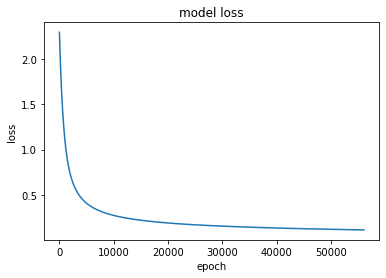

In [27]:
criterion = torch.nn.CrossEntropyLoss()

model = Linear_Model()

model, losses = train_torch_model(model, len(X_train_torch), criterion, max_epochs, X_train_torch, y_train_ohe_torch, lr, tolerance)

plot_loss(losses)

In [28]:
# print accuracies of model
train_accuracy,test_accuracy = print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

train_results.append(("Linear Model - PyTorch + CE Loss + Full Batch",train_accuracy))
test_results.append(("Linear Model - PyTorch + CE Loss + Full Batch",test_accuracy))

Train accuracy: 0.9798190675017397
Test accuracy: 0.9638888888888889


### Performing the same task above with `batch_size=64`. Also plotting the graph of loss vs epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.297011375427246
Epoch: 5000, Loss: 0.08772383630275726
Epoch: 10000, Loss: 0.06151024252176285
Epoch: 15000, Loss: 0.04865499213337898
Epoch: 20000, Loss: 0.040736522525548935


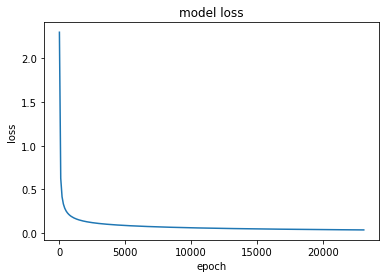

In [29]:
criterion = torch.nn.CrossEntropyLoss()

model = Linear_Model()

model, losses = train_torch_model(model, 64, criterion, max_epochs, X_train_torch, y_train_ohe_torch, lr, tolerance)

plot_loss(losses)

In [30]:
# print accuracies of model
train_accuracy,test_accuracy = print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

train_results.append(("Linear Model - PyTorch + CE Loss + Mini Batch",train_accuracy))
test_results.append(("Linear Model - PyTorch + CE Loss + Mini Batch",test_accuracy))

Train accuracy: 0.9979123173277662
Test accuracy: 0.9694444444444444




---



### Now, we will train a neural network in pytorch with two hidden layers of sizes 32 and 16 neurons. Using non-linear ReLU activations thus effectively making this a non-linear model. We will use this neural network model for multi-class classification with Cross Entropy Loss.

**Note:** The neural network model output can be represented mathematically as below:\
$\hat{y}^{(i)}_{10\times1} = W^{(3)}_{10\times 16}\sigma(W^{(2)}_{16\times 32}\sigma(W^{(1)}_{32\times 64}\mathbf{x}^{(i)}_{64\times1}+\mathbf{b}^{(1)}_{32\times1})+\mathbf{b}^{(2)}_{16\times1})+\mathbf{b}^{(3)}_{10\times1}$, \
where $\sigma$ represents ReLU activation, $W^{(i)}$ is the weight of the $i^{th}$ linear layer, and $\mathbf{b}^{(i)}$ is the layer's bias. We use the subscript to denote the dimension for clarity. 

### Defining the 2-hidden layer neural network model below.

In [31]:
# Defining a neural network model class using torch.nn
class NN_Model(torch.nn.Module):
    def __init__(self):
        super(NN_Model, self).__init__()

        # 1. initializing three linear layers: num_features -> 32, 32 -> 16, 16 -> num_targets
        self.fc1 = torch.nn.Linear(num_features, 32)
        self.fc2 = torch.nn.Linear(32, 16)
        self.fc3 = torch.nn.Linear(16, num_classes)
        # 2. initializing RELU
        self.relu = torch.nn.ReLU()
  
    def forward(self, X):
        # 3. defining the feedforward algorithm of the model and return the final output
        X = self.relu(self.fc1(X))
        X = self.relu(self.fc2(X))
        X = self.fc3(X)
  
        return X

### Training the newly defined Neural Network two hidden layer model with Cross Entropy Loss. Using full-batch and plotting the graph of loss vs number of epochs. 

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.316981792449951
Epoch: 5000, Loss: 0.21151939034461975
Epoch: 10000, Loss: 0.08753477036952972
Epoch: 15000, Loss: 0.05098190903663635
Epoch: 20000, Loss: 0.032722413539886475
Epoch: 25000, Loss: 0.022162584587931633


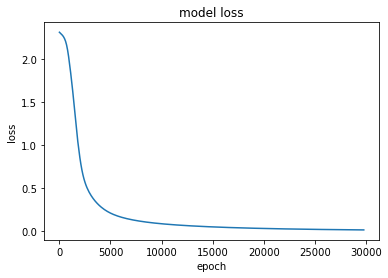

In [32]:
criterion = torch.nn.CrossEntropyLoss()

model = NN_Model()

model, losses = train_torch_model(model, len(X_train_torch), criterion, max_epochs, X_train_torch, y_train_ohe_torch, lr, tolerance)

plot_loss(losses)

In [33]:
# print accuracies of model
train_accuracy,test_accuracy = print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

train_results.append(("NN Model - PyTorch + CE Loss + Full Batch",train_accuracy))
test_results.append(("NN Model - PyTorch + CE Loss + Full Batch",test_accuracy))

Train accuracy: 0.9993041057759221
Test accuracy: 0.9611111111111111


### Re-training the above model with `batch_size=64`. Also plotting the graph of loss vs epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.2438511848449707


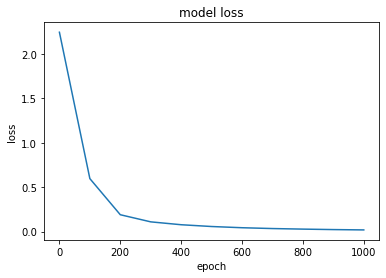

In [34]:
criterion = torch.nn.CrossEntropyLoss()

model = NN_Model()

model, losses = train_torch_model(model, 64, criterion, max_epochs, X_train_torch, y_train_ohe_torch, lr, tolerance)

plot_loss(losses)

In [35]:
# print accuracies of model
train_accuracy,test_accuracy = print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

train_results.append(("NN Model - PyTorch + CE Loss + Mini Batch",train_accuracy))
test_results.append(("NN Model - PyTorch + CE Loss + Mini Batch",test_accuracy))

Train accuracy: 0.9972164231036882
Test accuracy: 0.9527777777777777




---



### Plotting a graph of accuracy vs. model for both train and test sets for all the experiments performed above.

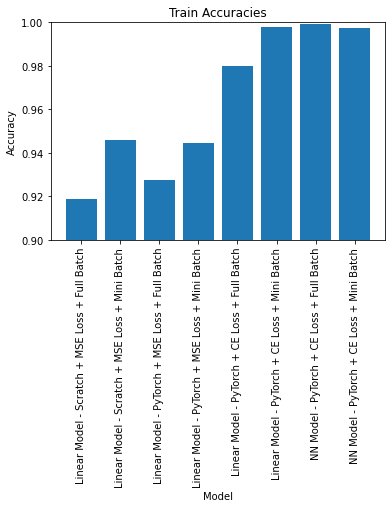

In [36]:
plt.bar(*zip(*train_results))
plt.ylim([0.9,1])
plt.title('Train Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation = 90)
plt.show()

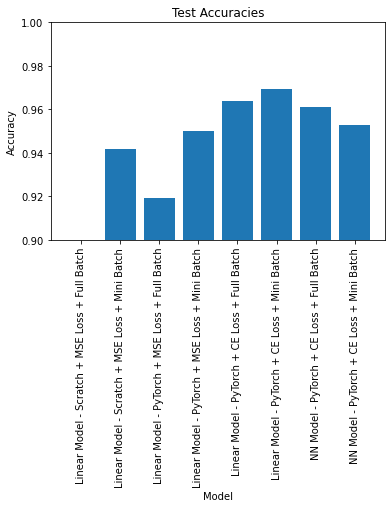

In [37]:
plt.bar(*zip(*test_results))
plt.ylim([0.9,1])
plt.title('Test Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation = 90)
plt.show()

### Analysis
#### Effect of using full vs. batch gradient descent.
1. Batch gradient descent converges faster than full gradient descent.
2. Batch gradient descent gives an approximate but not the optimal solution, full gradient descent always gives the optimal solution.

#### Effect of different loss strategy on performance.
1. MSE converged faster than Cross Entropy.
2. But the accuracy of Cross Entropy was much better than the MSE.

#### Effect of using linear vs. non-linear models.
1. Linear Model performed better than Non-linear for Mini Batch
2. But for Full Batch, Non-linear performed better than Linear Model.

#### Training time per epoch in different cases.
1. Non Linear model for both Full and Mini batch took the least time per epoch.
2. Linear with Cross Entropy, full batch was faster than mini batch.
3. Linear with MSE, full batch was faster than mini batch. And both were faster in comprison to Linear with Cross Entropy.
4. Scratch Linear Model with MSE, full batch was faster than mini batch. Overall, in comparison to Linear Models, this was the fastest.

---